# Titanic: Machine Learning from Disaster

# The Challenge

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

# Abstract

Use various techniques of Feature Engineering, Classification and Regression algorithms to achieve more accurate predictions.

We will be utilising ensemble learning by applying several algorithms interchangeably.

The best score achived on Kaggle using techniques below is `79.904%`.

# Tools we would need

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, median_absolute_error, max_error, explained_variance_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from xgboost import XGBRegressor, plot_importance 

import lightgbm as lgb

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from keras.optimizers import RMSprop 
from keras.callbacks import EarlyStopping 
import keras

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import threading
import re

sns.set()

TrainData =  pd.read_csv('input/train.csv')
TestData = pd.read_csv('input/test.csv')

Using TensorFlow backend.


# Feature engineering

## Interpolation of missing values

One can notice that in traing and testing data sets combined there are:
- **1014** passengers with missing `Cabin`
- **418** passengers with missing `Survived` value
- **263** passengers with missing `Age`
- **2** passengers with missing `Embarked` port
- **1** record with missing `Fare` value

We will try to approximate those values below.

In [2]:
traind = TrainData.copy()
testd = TestData.copy()
td_merged = traind.append(testd, ignore_index=True)
td_merged.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### Retrieve Title from Name

In [3]:
# Retrieve title from Name, we will use it as a feature
for index, person in td_merged.iterrows():
    found = re.match(r".+ (.+\.).*", person.Name)
    if found:
        td_merged.loc[index, 'Title'] = found.group(1)

td_filtered = td_merged.drop(['PassengerId','Name',],axis=1)

### Fill missing `Embarked` values

In [4]:
# According to publicly available report, those 2 ladies embarked in Southampton
td_filtered[['Embarked']] = td_filtered[['Embarked']].fillna('S')

### Fill missing `Fare` value

In [5]:
# There's only 1 missing fare for a senior citezen, we'll use a median fare
# among other people on board of the same age
missing_fare = float(td_filtered[['Pclass','Age','Fare']]
                     [(td_filtered.Age > 50) & (td_filtered.Pclass == 3)]
                     .groupby(['Pclass']).median().Fare)
td_filtered[['Fare']] = td_filtered[['Fare']].fillna(missing_fare)

### Use `Cabin`'s first letter as sector identifier on the ship

In [6]:
# Use first cabin latter to distinguish location on the ship
td_filtered.Cabin = td_filtered.Cabin[td_filtered.Cabin.notnull()].apply(lambda c: c[0])

### Restore age by title

It a known fact that title `Master` belongs to boys.

>The abbreviation Mr. has been in use since the fifteenth century, it is a variant of the word master. Master is still occasionally used as a title for a boy, there is no abbreviation.

At this point we are going to assign an average kid age to those kids with absent `Age`.

In [7]:
pd.options.mode.chained_assignment = None
masters = td_filtered[(td_filtered.Title == 'Master.')]
masters_without_age = masters[(masters.Age.isnull())]
master_mean_age = masters[(masters.Age.notnull())]['Age'].mean()
masters_without_age['Age'] = master_mean_age
td_filtered.update(masters_without_age)



### Aggregate redundant titles


#### Related to a royalty or possession of a high rank
Earl. and Countess. are in the third degree of the U.K. Peerage System known as British nobility (e.g. Prince Edward, Earl of Wessex, of his wife Countess of Wessex).

Jonkheer. of person related to the Dutch Nobility System

Sir./Dame. of person knighted by the Queen.

L.(Lord)/Lady., Don./Dona. - in the U.K., Barons, viscounts, earls, marquesses and their female counterparts can all be referred to as lord or lady instead of their full title, as can their children.

#### Military
Major., Col., Capt

#### Religion
Rev. stands for the Reverend, a Christian cleric such as an pastor or priest. 

#### Academic
Dr. of a person who has obtained a doctorate (e.g. PhD).

#### Unknown marital status
Mr./Ms.

#### Unmarried woman
Miss. 
Mlle. stands for Mademoiselle in French

#### Married woman
Mrs. is a title of married or widowed woman

Mme. stands for Madame in French

In [8]:
sorted(td_merged.Title.unique())

# Countess., Jonkheer., Sir., Dame., L., Lady., Don., Dona. -> High rank
# Major., Col., Capt. -> Military
# Rev. -> Religion
# Dr. -> Academic
# Mrs., Mme. -> Married
# Miss., Mlle. -> Unmarried
# Master -> Child
# Mr., Ms. -> Unknown

# of a High rank
td_filtered.Title[(td_filtered.Title.isin(['Countess.', 'Jonkheer.', 'Sir.', 'Dame.', 'L.', 'Lady.', 'Don.', 'Dona.']))] = 'High rank'
# Married
td_filtered.Title[(td_filtered.Title.isin(['Mrs.','Mme.']))] = 'Married'
# Unmarried
td_filtered.Title[(td_filtered.Title.isin(['Miss.','Mlle.']))] = 'Unmarried'
# Academic
td_filtered.Title[(td_filtered.Title.isin(['Dr.']))] = 'Academic'
# Unknown
td_filtered.Title[(td_filtered.Title.isin(['Mr.','Ms.']))] = 'Undefined'
# Child
td_filtered.Title[(td_filtered.Title.isin(['Master.']))] = 'Child'
# Religion
td_filtered.Title[(td_filtered.Title.isin(['Rev.']))] = 'Religion'
# Military
td_filtered.Title[(td_filtered.Title.isin(['Major.', 'Col.', 'Capt.']))] = 'Married'

td_filtered.groupby('Title').size()

Title
Academic       8
Child         61
High rank      7
Married      204
Religion       8
Undefined    759
Unmarried    262
dtype: int64

### Setting family category

In [9]:
td_family_size = td_filtered.copy()
td_family_size['FamilySize'] = (td_filtered.SibSp + td_filtered.Parch + 1)
td_filtered['FamilyCategory'] = pd.cut(td_family_size.FamilySize,[0,1,2,3,4],labels=['Single','Small','Medium','Large'],duplicates='drop')
td_filtered.groupby(['FamilyCategory','Pclass']).size().unstack()

Pclass,1.0,2.0,3.0
FamilyCategory,,,
Single,160,158,472
Small,104,52,79
Medium,39,45,75
Large,9,20,14


## Categorical feature encoding
* `Sex` - we have discovered only 2 possible genders in the data: _male_ and _female_
* `Ticket` - some tickets are reoccurring, perhaps shared among passengers tagging along in group (family members, tourists, friends, etc.)
* `Cabin` - Some cabins are also shared among passengers
* `Embarked` - this feature has 3 ports, some of the passengers (2 ladies from _Southampton_ ) have this field missing, we will manually populate those entries, as this information is publically available
* `Title` - We will extract title (_Mr._ , _Ms._ , _Mrs._ , etc.) from the name. Perhaps, it's worth to have a look at surname, and play around with that feature to predict survival rate of particular family members but for now we will drop it and use title only.

Apart from `Name`, we are also dropping `PassengerId` to avoid our models allocating excessive weights to irrelevant features.

In [10]:
categorical_features = ['Sex','Cabin','Embarked', 'Title','FamilyCategory','Ticket']
encoders = dict()
for feature in categorical_features:
    enc = LabelEncoder()
    encoders[feature] = enc
    td_filtered.loc[:,feature] = enc.fit_transform(td_filtered[feature].astype(str))

## Feature relationship analysis

In this step we will discover how different features correlate with each other and prepare a set of important variables to feed to our predictive models later.

### Heatmap

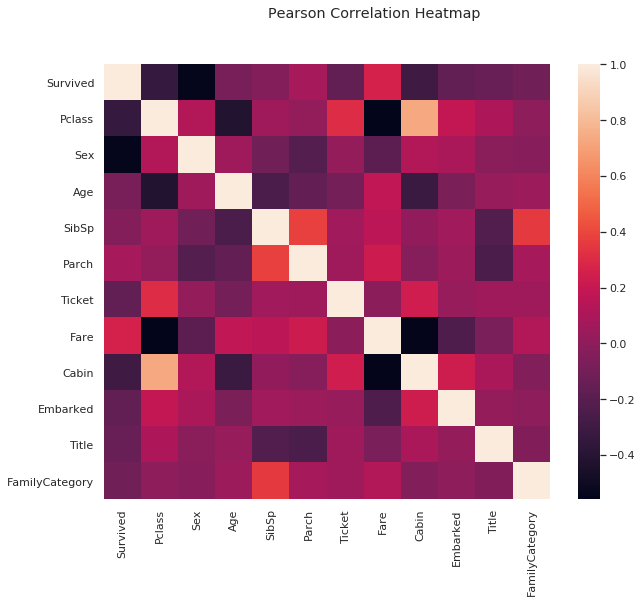

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilyCategory
Survived,1.00,-3.38e-01,-0.54,-0.08,-3.53e-02,0.08,-0.17,0.26,-3.01e-01,-1.68e-01,-0.14,-1.12e-01
Pclass,-0.34,1.00e+00,0.12,-0.41,6.08e-02,0.02,0.31,-0.56,7.35e-01,1.85e-01,0.11,-4.59e-04
Sex,-0.54,1.25e-01,1.00,0.05,-1.10e-01,-0.21,0.02,-0.19,1.25e-01,9.80e-02,-0.02,-2.57e-02
Age,-0.08,-4.14e-01,0.05,1.00,-2.53e-01,-0.16,-0.09,0.18,-3.16e-01,-7.02e-02,0.03,4.85e-02
SibSp,-0.04,6.08e-02,-0.11,-0.25,1.00e+00,0.37,0.06,0.16,7.95e-03,6.56e-02,-0.23,3.55e-01
Parch,0.08,1.83e-02,-0.21,-0.16,3.74e-01,1.00,0.05,0.22,-3.44e-02,4.48e-02,-0.25,8.28e-02
Ticket,-0.17,3.10e-01,0.02,-0.09,6.39e-02,0.05,1.00,-0.01,2.33e-01,3.15e-02,0.05,6.11e-02
Fare,0.26,-5.59e-01,-0.19,0.18,1.60e-01,0.22,-0.01,1.00,-5.47e-01,-2.38e-01,-0.08,1.26e-01
Cabin,-0.30,7.35e-01,0.13,-0.32,7.95e-03,-0.03,0.23,-0.55,1.00e+00,2.31e-01,0.10,-4.70e-02
Embarked,-0.17,1.85e-01,0.10,-0.07,6.56e-02,0.04,0.03,-0.24,2.31e-01,1.00e+00,0.02,-3.44e-03


In [11]:
pd.set_option('precision',2)
plt.figure(figsize=(10, 8))
sns.heatmap(td_filtered.corr())
plt.suptitle("Pearson Correlation Heatmap")
plt.show();
td_filtered.corr()

### Closer look on `Gender`, `Age` and `Class` 

From age and gender insights we can observe that passengers of the First class got the best survival rate followed by the Second class and the Third as the last one. Probably because passengers of the 3rd class ended up to be locked in their cabins, that might have been done to reduce sinking rate of the ship so that more lifes could have be saved.

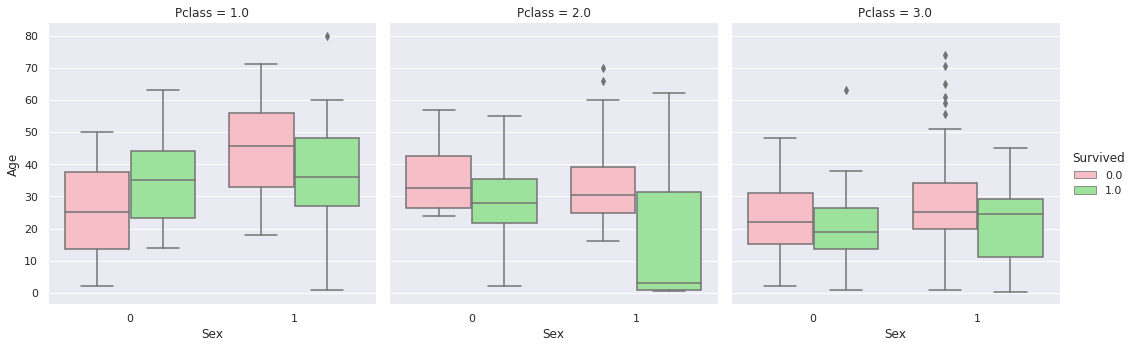

In [12]:
ax = sns.catplot(x='Sex', y='Age', hue='Survived', data=td_filtered, kind="box", col='Pclass',
               palette=['lightpink','lightgreen'])

## Feature recovery

### Regression analysis of `Age`

For this model we are going to drop `Ticket` feature here, as it reduces error rate of prediction.

In [13]:
td_with_age = td_filtered[(~td_filtered.Age.isnull())]
td_without_age = td_filtered[(td_filtered.Age.isnull())].drop(['Age'], axis=1)

X = td_with_age.drop(['Age'], axis=1)
Y = td_with_age.Age

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=10)


#### Gradient boosting with LightGBM

R2 Score (best is 1.0): 0.413632253065786
MedAE (the smaller the better): 7.7251463048737605
Max Error: 19.660476886331566
ExpVar score (best is 1.0): 0.5105419740928383
RMSE: 9.420133527623808


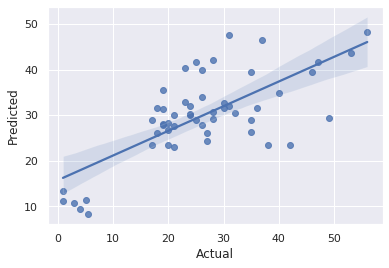

In [14]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'num_threads': threading.active_count(),
}

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

modelLGB = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_eval,
                early_stopping_rounds=10, verbose_eval=0)

predictions = modelLGB.predict(X_test, num_iteration=modelLGB.best_iteration)

print('R2 Score (best is 1.0): %s' % r2_score(y_test.to_numpy(), predictions))
print('MedAE (the smaller the better): %s' % median_absolute_error(y_true=y_test.to_numpy(),y_pred=predictions))
print('Max Error: %s' % max_error(y_true=y_test.to_numpy(),y_pred=predictions))
print('ExpVar score (best is 1.0): %s' % explained_variance_score(y_true=y_test.to_numpy(),y_pred=predictions))
print('RMSE:', mean_squared_error(y_test, predictions) ** 0.5)

feature_importance = pd.DataFrame()
feature_importance['Score'] = modelLGB.feature_importance()
feature_importance['Feature'] = modelLGB.feature_name()
feature_importance = feature_importance.sort_values(by='Score',ascending=False)

temp = pd.DataFrame()
temp['Actual'] = y_test
temp['Predicted'] = predictions

ax = sns.regplot(x='Actual',y='Predicted',data=temp)

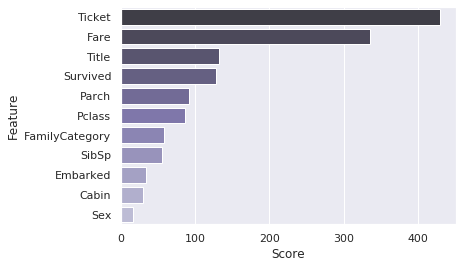

In [15]:
ax = sns.barplot(x='Score',y='Feature',data=feature_importance, palette="Purples_d", orient='h')

#### Gradient boosting with XGBoost

R2 Score (best is 1.0): 0.5605619120471698
MedAE (the smaller the better): 5.6801910400390625
Max Error: 19.14730453491211
ExpVar score (best is 1.0): 0.5630424569042021
RMSE: 8.154941876776922


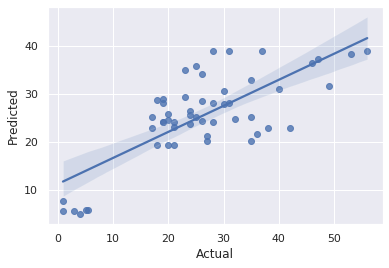

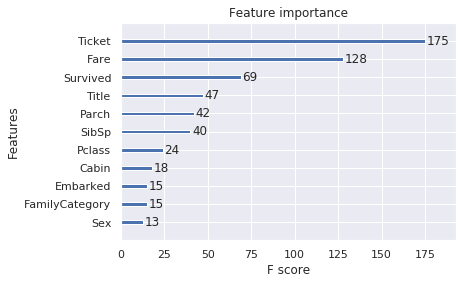

In [16]:
modelXGB = XGBRegressor(n_estimators=100)
modelXGB.fit(X_train, y_train, early_stopping_rounds=10, 
             eval_set=[(X_test, y_test)], verbose=False)
predictions = modelXGB.predict(X_test)
print('R2 Score (best is 1.0): %s' % r2_score(y_test.to_numpy(), predictions))
print('MedAE (the smaller the better): %s' % median_absolute_error(y_true=y_test.to_numpy(),y_pred=predictions))
print('Max Error: %s' % max_error(y_true=y_test.to_numpy(),y_pred=predictions))
print('ExpVar score (best is 1.0): %s' % explained_variance_score(y_true=y_test.to_numpy(),y_pred=predictions))
print('RMSE:', mean_squared_error(y_test, predictions) ** 0.5)

temp = pd.DataFrame()
temp['Actual'] = y_test
temp['Predicted'] = predictions
sns.regplot(x='Actual',y='Predicted',data=temp)

plot_importance(modelXGB)

plt.show()

Looks like **XGBoost** does a better job at regression. 

We will go with the results produced by **XGBoost** in this case as the predictions indicates slightly lower error rates comparing to **LightGBM**

#### Populating missing `Age` values with results of our prediction

In [17]:
predictions = modelXGB.predict(td_without_age)
td_age_restored = td_without_age.copy()
td_age_restored.loc[:,'Age'] = predictions
td_filtered.update(td_with_age.append(td_age_restored))
td_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Survived        891 non-null    float64
 1   Pclass          1309 non-null   float64
 2   Sex             1309 non-null   int64  
 3   Age             1309 non-null   float64
 4   SibSp           1309 non-null   float64
 5   Parch           1309 non-null   float64
 6   Ticket          1309 non-null   int64  
 7   Fare            1309 non-null   float64
 8   Cabin           1309 non-null   int64  
 9   Embarked        1309 non-null   int64  
 10  Title           1309 non-null   int64  
 11  FamilyCategory  1309 non-null   int64  
dtypes: float64(6), int64(6)
memory usage: 122.8 KB


### Classification of missing `Cabin` (sector of the ship) values

In [18]:
td_with_cabin = td_filtered[(td_filtered.Cabin.notna())].drop(['Survived'], axis=1)
td_without_cabin = td_filtered[(td_filtered.Cabin.isna())].drop(['Cabin','Survived'], axis=1)

X = td_with_cabin.drop(['Cabin'], axis=1)

input_features = X.columns.values
n_input_features = len(input_features)
n_output_feature = len(td_with_cabin.Cabin.unique())

Y = td_with_cabin.Cabin

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=10)

#### Predicting with multiple layer Neural Networks (Keras & TF)

In [19]:
modelNN = Sequential([
    Dense(n_input_features, input_dim=n_input_features, activation='relu'),
    Dense(n_input_features * 4, activation='relu'),
    Dense(n_input_features * 4, activation='relu'),
    Dropout(0.1),
    Dense(n_output_feature, activation='softmax'),
])
modelNN.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
modelNN.summary()
modelNN.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_test, y_test),
    verbose = 1
)
loss, accuracy = modelNN.evaluate(X_test, y_test)
print("Accuracy: %s" % accuracy)
print("Loss: %s" % loss)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 40)                440       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 369       
Total params: 2,559
Trainable params: 2,559
Non-trainable params: 0
_________________________________________________________________
Train on 1243 samples, validate on 66 samples
Epoch 1/30
1243/1243 [==============================] - 0s 176us/step - 

##### Model overview

The result produced by the model: **74% of accuracy** and **65% of loss** is somewhat not satisfying at all for this task!

#### Trying to classify with XGBoost

In [20]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = { 
    'objective': 'multi:softmax',
    'learning_rate': 0.3,
    'max_depth': 6,
    'eta': 0.1,
    'nthread': threading.active_count(),
    'num_class': n_output_feature,
}
modelXGB = xgb.train(params=params,dtrain=dtrain,num_boost_round=100)
predictions = modelXGB.predict(dtest)

##### Model overview

Excellent result - 95% of accuracy!

In [21]:
print('Accuracy: %s' % accuracy_score(y_test, predictions))
print('Error rate: %s' % (np.sum(predictions != y_test) / y_test.shape[0]))
print('MSE: %s' % mean_squared_error(y_test, predictions))
print('MedAE: %s' % median_absolute_error(y_true=y_test,y_pred=predictions))
print('Max Error: %s' % max_error(y_true=y_test,y_pred=predictions))
print('ExpVar score: %s' % explained_variance_score(y_true=y_test,y_pred=predictions))

Accuracy: 0.9545454545454546
Error rate: 0.045454545454545456
MSE: 1.3333333333333333
MedAE: 0.0
Max Error: 6.0
ExpVar score: 0.7780525502318393


#### Populating predicted values

In [22]:
predictions = modelXGB.predict(xgb.DMatrix(td_without_cabin))
missing_cabins = np.array(predictions,dtype=int)
td_cabins_restored = td_without_cabin.copy()
td_cabins_restored.loc[:,'Cabin'] = missing_cabins
td_filtered.update(td_with_cabin.append(td_cabins_restored))
td_filtered['Survived'] = TrainData.Survived
td_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Survived        891 non-null    float64
 1   Pclass          1309 non-null   float64
 2   Sex             1309 non-null   int64  
 3   Age             1309 non-null   float64
 4   SibSp           1309 non-null   float64
 5   Parch           1309 non-null   float64
 6   Ticket          1309 non-null   int64  
 7   Fare            1309 non-null   float64
 8   Cabin           1309 non-null   int64  
 9   Embarked        1309 non-null   int64  
 10  Title           1309 non-null   int64  
 11  FamilyCategory  1309 non-null   int64  
dtypes: float64(6), int64(6)
memory usage: 122.8 KB


Now we have all of our missing values recovered except the only one `Survived`. 

Let's jump to our final goal -- guess who survived and who did not.

### Classification of `Survived` passengers

In [23]:
training_data = td_filtered[(~td_filtered.Survived.isnull())].drop(['Fare'],axis=1)
testing_data = td_filtered[(td_filtered.Survived.isnull())].drop(['Survived','Fare'],axis=1)

X = training_data.drop(['Survived'],axis=1)
Y = training_data.Survived

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=10)

#### Binary logistic regression with `LightGBM`

In [24]:
param = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'feature_fraction': 1,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'num_threads': threading.active_count(),
}
param['metric'] = ['auc', 'binary_logloss']

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

modelLGB = lgb.train(param, lgb_train, num_boost_round=50, valid_sets=lgb_eval, early_stopping_rounds=10)

[1]	valid_0's auc: 0.850962	valid_0's binary_logloss: 0.603757
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.824519	valid_0's binary_logloss: 0.587699
[3]	valid_0's auc: 0.838942	valid_0's binary_logloss: 0.57104
[4]	valid_0's auc: 0.862981	valid_0's binary_logloss: 0.555134
[5]	valid_0's auc: 0.867788	valid_0's binary_logloss: 0.541185
[6]	valid_0's auc: 0.860577	valid_0's binary_logloss: 0.529578
[7]	valid_0's auc: 0.862981	valid_0's binary_logloss: 0.518851
[8]	valid_0's auc: 0.867788	valid_0's binary_logloss: 0.508994
[9]	valid_0's auc: 0.867788	valid_0's binary_logloss: 0.499373
[10]	valid_0's auc: 0.870192	valid_0's binary_logloss: 0.490179
[11]	valid_0's auc: 0.875	valid_0's binary_logloss: 0.479415
[12]	valid_0's auc: 0.879808	valid_0's binary_logloss: 0.468586
[13]	valid_0's auc: 0.882212	valid_0's binary_logloss: 0.459442
[14]	valid_0's auc: 0.884615	valid_0's binary_logloss: 0.45015
[15]	valid_0's auc: 0.884615	valid_0's binary_logloss: 0.

##### Model overview

Accuracy: 0.8894230769230769
Binary logloss: 0.42896602264064176


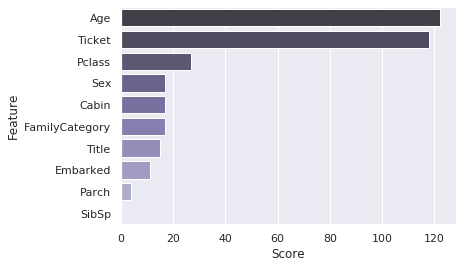

In [25]:
print('Accuracy: %s' % modelLGB.best_score['valid_0']['auc'])
print('Binary logloss: %s' % modelLGB.best_score['valid_0']['binary_logloss'])

feature_importance = pd.DataFrame()
feature_importance['Score'] = modelLGB.feature_importance()
feature_importance['Feature'] = modelLGB.feature_name()
feature_importance = feature_importance.sort_values(by='Score',ascending=False)

ax = sns.barplot(x='Score',y='Feature',data=feature_importance, palette="Purples_d", orient='h')

#### Binary logistic regression with `XGBoost`

Despite the name of the algorithm suggests the word "regression" we're going to perform classification underneath.

In order to answer to the question like "Did this passenger survive the disaster?" -- the possible answer can contain only 2 possible outcomes: `True` or `False`.

Let's see what rate of accuracy we can achieve with this model.

In [26]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = { 
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'max_depth': 6,
    'eta': 0.01,
    'nthread': threading.active_count(),
}
modelXGB = xgb.train(params=params,dtrain=dtrain,num_boost_round=40)
predictions = modelXGB.predict(dtest)

##### Model overview

We achieved quite a good result:


In [27]:
print('Accuracy: %s' % accuracy_score(y_test, predictions.round()))
print('MSE: %s' % mean_squared_error(y_test, predictions.round()))

Accuracy: 0.8
MSE: 0.2


##### Decision tree

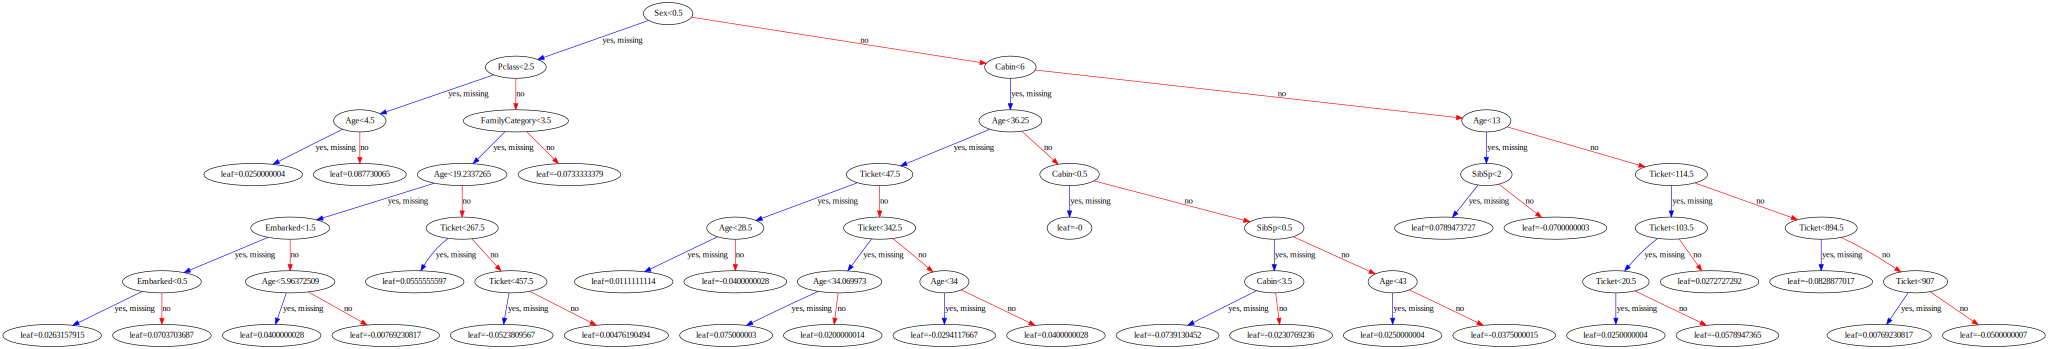

In [28]:
xgb.to_graphviz(modelXGB)

##### Feature importance

- From my point of view it doesn't look so obvious why our model picked up `Ticket` as the most important feature. My guess here would be that passengers in group has the best chance to escape the sinking ship. But strange that eliminating this feature gives worse accuracy score. So we will keep it as it is.

- Secondly, looks like `Age` contributes heavily to survival probability after whether the passenger was in group or alone. This drives to conclusion that passengers of particular age group have higher chances to survive.

- `Fare` and `Cabin` sector are the next deciders in this game of dice.

- Class and gender don't play so crucial role as it might appeared in the beginning.

- Apperantly a particular `Title` or whether the passenger is a parent or children (`Parch`) contribute very little to importance

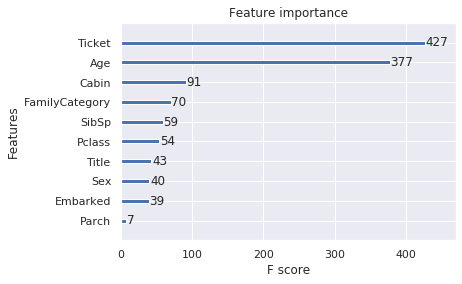

In [29]:
plot_importance(modelXGB)
plt.show()

#### KNN - K Nearest Neighbours with `scikit-learn`

In [30]:
modelKNN = KNeighborsClassifier(n_neighbors=10)
modelKNN.fit(X_train, y_train)
predictions = modelKNN.predict(X_test)

##### Model overview

Quite a surprise -- KNN and Gradient Boosting ended up predicting with the same rate of accuracy!

In [31]:
print('Accuracy: %s' % accuracy_score(y_test, predictions.round()))
print('MSE: %s' % mean_squared_error(y_test, predictions.round()))

Accuracy: 0.7333333333333333
MSE: 0.26666666666666666


#### Neural network with multiple layers (`Keras` & `TF`)

In [32]:
neurons=len(testing_data.columns.values)
modelNN = Sequential([
    Dense(neurons * 8, input_dim=neurons, activation='relu'),
    Dense(neurons * 3, activation='relu'),
    Dense(neurons * 1, activation='relu'),
    Dense(1, activation='sigmoid'),
])

modelNN.compile(
    loss='mse',
    optimizer='adam',
    metrics=['accuracy']
)

modelNN.fit(
    X_train, y_train,
    epochs=5, batch_size=10,
    validation_data=(X_test, y_test),
    verbose = 1
)

Train on 846 samples, validate on 45 samples
Epoch 1/5
846/846 [==============================] - 0s 263us/step - loss: 0.2442 - accuracy: 0.6111 - val_loss: 0.2558 - val_accuracy: 0.3111
Epoch 2/5
846/846 [==============================] - 0s 133us/step - loss: 0.2378 - accuracy: 0.5827 - val_loss: 0.2177 - val_accuracy: 0.7333
Epoch 3/5
846/846 [==============================] - 0s 122us/step - loss: 0.2362 - accuracy: 0.6017 - val_loss: 0.2162 - val_accuracy: 0.7333
Epoch 4/5
846/846 [==============================] - 0s 111us/step - loss: 0.2325 - accuracy: 0.6064 - val_loss: 0.2110 - val_accuracy: 0.7111
Epoch 5/5
846/846 [==============================] - 0s 108us/step - loss: 0.2325 - accuracy: 0.6158 - val_loss: 0.2182 - val_accuracy: 0.7333


##### Model overview

In [33]:
loss, accuracy = modelNN.evaluate(X_test, y_test)
print("Accuracy: %s" % accuracy)
print("Loss: %s" % loss)

45/45 [==============================] - 0s 84us/step
Accuracy: 0.7333333492279053
Loss: 0.2181989785697725


#### Convolutional Neural Network with 1x1 dimension (`Keras` & `TF`)

In [34]:
modelCNN = Sequential([
    Conv1D(filters=neurons, kernel_size=2, input_shape=(neurons,1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.1),
    Flatten(),
    Dense(neurons * 2, activation='relu'),
    Dense(1, activation='sigmoid'),
])

modelCNN.compile(
   loss = 'mse',
   optimizer = 'adam',
   metrics = ['accuracy']
)

X_train_reshaped = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)

modelCNN.fit(
    X_train_reshaped, y_train,
    epochs=5,
    validation_data=(X_test_reshaped, y_test),
    verbose = 1
)

Train on 846 samples, validate on 45 samples
Epoch 1/5
846/846 [==============================] - 0s 402us/step - loss: 0.3929 - accuracy: 0.5768 - val_loss: 0.2769 - val_accuracy: 0.7111
Epoch 2/5
846/846 [==============================] - 0s 80us/step - loss: 0.3886 - accuracy: 0.5875 - val_loss: 0.2626 - val_accuracy: 0.6889
Epoch 3/5
846/846 [==============================] - 0s 48us/step - loss: 0.3973 - accuracy: 0.5780 - val_loss: 0.2851 - val_accuracy: 0.7111
Epoch 4/5
846/846 [==============================] - 0s 43us/step - loss: 0.3784 - accuracy: 0.5887 - val_loss: 0.2823 - val_accuracy: 0.6889
Epoch 5/5
846/846 [==============================] - 0s 42us/step - loss: 0.4029 - accuracy: 0.5686 - val_loss: 0.2663 - val_accuracy: 0.7111


##### Model overview

Worst result! I know... this domain of problem is not suitable for CNN as the data set isn't large enough, so the model ended up underfitted -- I'm just experimenting :)

In [35]:
loss, accuracy = modelCNN.evaluate(X_test_reshaped, y_test)
print("Accuracy: %s" % accuracy)
print("Loss: %s" % loss)

45/45 [==============================] - 0s 143us/step
Accuracy: 0.7111111283302307
Loss: 0.26629787915282777


### Feed testing data set

In [36]:
TestDataReshaped = testing_data.to_numpy().reshape(testing_data.shape[0],testing_data.shape[1],1)
OutputCNN = testing_data.copy()
OutputCNN["Survived"] = modelCNN.predict_classes(TestDataReshaped)
OutputCNN['PassengerId'] = td_merged.PassengerId.astype(int)

In [37]:
OutputNN = testing_data.copy()
OutputNN["Survived"] = modelNN.predict_classes(testing_data.to_numpy())
OutputNN['PassengerId'] = td_merged.PassengerId.astype(int)

In [38]:
OutputXGB = testing_data.copy()
OutputXGB["Survived"] = np.array(
    modelXGB.predict(
        xgb.DMatrix(testing_data.to_numpy(), feature_names=testing_data.columns.values)
    ).round()
    ,dtype=int)
OutputXGB['PassengerId'] = td_merged.PassengerId.astype(int)

In [39]:
OutputKNN = testing_data.copy()
OutputKNN["Survived"] = modelKNN.predict(testing_data.to_numpy())
OutputKNN.Survived = OutputKNN.Survived.astype(int)
OutputKNN['PassengerId'] = td_merged.PassengerId.astype(int)

In [40]:
OutputLGB = testing_data.copy()
OutputLGB["Survived"] = np.array(modelLGB.predict(testing_data.to_numpy(), num_iteration=modelLGB.best_iteration).round(),dtype=int)
OutputLGB['PassengerId'] = td_merged.PassengerId.astype(int)

### Save predictions to file

In [41]:
OutputLGB[['PassengerId', 'Survived']].to_csv('output/LGB.csv', index=False)
OutputXGB[['PassengerId', 'Survived']].to_csv('output/XGB.csv', index=False)
OutputCNN[['PassengerId', 'Survived']].to_csv('output/CNN.csv', index=False)
OutputNN[['PassengerId', 'Survived']].to_csv('output/NN.csv', index=False)
OutputKNN[['PassengerId', 'Survived']].to_csv('output/KNN.csv', index=False)